## Day44 - Word Embedding + Vector Representation t-SNE

In [58]:
import numpy as np
from annoy import AnnoyIndex

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
import numpy as np
from annoy import AnnoyIndex

class PreTrainedEmbeddings(object):
    def __init__(self, word_to_index, word_vectors):
        """
        :param word_to_index (dict): mapping from word to integers
        :param word_vectors (list of numpy arrays)
        """
        self.word_to_index = word_to_index
        self.word_vectors = word_vectors
        self.index_to_word = {v: k for k, v in self.word_to_index.items()}
        self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean')
        for _, i in self.word_to_index.items():
            self.index.add_item(i, self.word_vectors[i])

        self.index.build(50)

  
    @classmethod
    def from_embeddings_file(cls, embedding_file):
        """Instantiate from pretrained vector file.
        Vector file should be of the format:
        word0 x0_0 x0_1 x0_2 x0_3 ... x0_N
        word1 x1_0 x1_1 x1_2 x1_3 ... x1_N
        Args:
        embedding_file (str): location of the file
        Returns:
        instance of PretrainedEmbeddings
        """
        word_to_index = {}
        word_vectors = []

        with open(embedding_file, encoding="UTF-8") as fp:
              for line in fp.readlines():
                line = line.split(" ")
                word = line[0]
                vec = np.array([float(x) for x in line[1:]])
                word_to_index[word] = len(word_to_index)
                word_vectors.append(vec)

        return cls(word_to_index, word_vectors)
    
    def get_embedding(self, word):
        """
        :param word (str):
        :return embedding (numpy.ndarray):
        """
        return self.word_vectors[self.word_to_index[word]]
    
    def get_closest_to_vector(self, vector, n=1):
        """Given a vector, return its n nearest neighbors
        Args:
        vector (np.ndarray): should match the size of the vectors
        in the Annoy index
        n (int): the number of neighbors to return
        Returns:
        [str, str, ...]: words nearest to the given vector
        The words are not ordered by distance
        """
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.index_to_word[neighbor] for neighbor in nn_indices]

    def compute_and_print_analogy(self, word1, word2, word3):
        """ Prints the solutions to analogies using word embeddings
            Analogies are word1 is to word2 as word3 is to __
            This method will print: word1 : word2 :: word3 : word4
        
        :param word1 (str):
        :param word2 (str):
        :param word3 (str):
        """
        vec1 = self.get_embedding(word1)
        vec2 = self.get_embedding(word2)
        vec3 = self.get_embedding(word3)
        
        vec_list = [vec1,vec2,vec3]
        label_list = [word1,word2,word3]
        
        # Simple hypothesis: Analogy is a spatial relationship
        spatial_relationship = vec2 - vec1
        vec4 = vec3 + spatial_relationship
        closest_words = self.get_closest_to_vector(vec4, n=4)
        existing_words = set([word1, word2, word3])
        closest_words = [word for word in closest_words if word not in existing_words]

        if len(closest_words) == 0:
            print("Could not find nearest neighbors for the vector!")
            
        else: 
            for word4 in closest_words:
                print("{} : {} :: {} : {}".format(word1, word2, word3, word4))
                vec_list.append(self.get_embedding(word4))
                label_list.append(word4)
            
        return vec_list, label_list


In [100]:
embeddings = PreTrainedEmbeddings.from_embeddings_file('../dataset/glove.6B.100d.txt')

In [101]:
vec_list, label_list = embeddings.compute_and_print_analogy('man', 'he', 'woman')

man : he :: woman : she
man : he :: woman : her


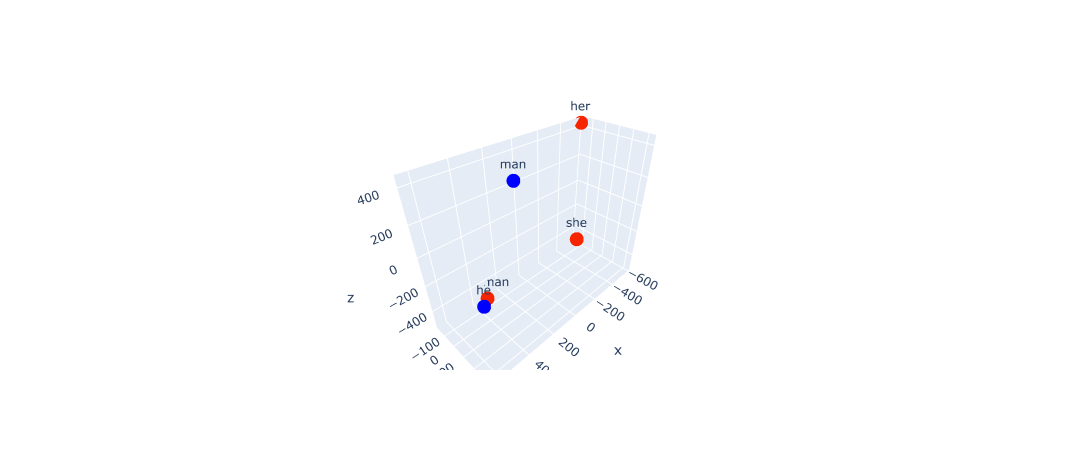

In [115]:
tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vec_list)

x = []
y = []
z = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])


colors = ['#0000ff','#0000ff']
for i in range(len(x)-2):
    colors.append('#f72400')
    
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode="markers+text",
    text=label_list,
    marker=dict(color=colors)
))



fig.show()